<a href="https://colab.research.google.com/github/CliffordDelaCruz/ML_study/blob/main/CNN_Practice_Project_SVHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Networks: Street View Housing Number Digit Recognition**

Welcome to the project on classification using Convolutional Neural Networks. We will continue to work with the Street View Housing Numbers (SVHN) image dataset for this project.

--------------
### **Context:** 
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents.
 

----------------
### **Objective:**
----------------

To build a CNN model that can recognize the digits in the images.

-------------
### **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**
Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras.utils import to_categorical

**Let us check for the version of tensorflow.**

In [3]:
print(tf.__version__)

2.12.0


## **Load the dataset**
- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [6]:
import h5py

# Open the file as read only
# User can make changes in the path as required
h5f = h5py.File('/content/drive/MyDrive/Colab Notebooks/SVHN_single_grey1.h5', 'r')

# Load the training and the test set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

Let's check the number of images in the training and the testing dataset.

In [7]:
len(X_train), len(X_test)

(42000, 18000)

**Observation:**
- There are 42,000 images in the training data and 18,000 images in the testing data. 

## **Visualizing images**
- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

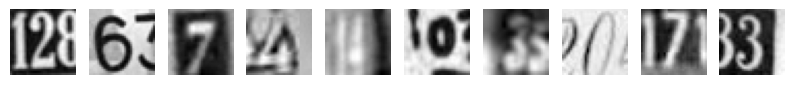

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [8]:
# Visualizing the first 10 images in the dataset and their labels

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
plt.show()

print('label for each of the above image: %s' % (y_train[0:10]))

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test set.
- One-hot encode the target variable.

In [9]:
# Shape of the images and the first image
print("Shape:", X_train[0].shape)
print()
print("First image:\n", X_train[0])

Shape: (32, 32)

First image:
 [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


In [10]:
# Reshaping the dataset to flatten them. Remember that we always have to give a 4D array as input to CNNs
X_train = X_train.reshape(X_train.shape[0], 32,32,1)
X_test = X_test.reshape(X_test.shape[0], 32,32,1)

In [11]:
# Normalize inputs from 0-255 to 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
# New shape 
print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (42000, 32, 32, 1) (42000,)
Test set: (18000, 32, 32, 1) (18000,)


In [13]:
# One-hot encode output
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Test labels
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

**Observation:**
- Notice that each entry of the target variable is a one-hot encoded vector instead of a single label.

## **Model Building**

Now, we have done data preprocessing, let's build a CNN model.

In [14]:
# Fixing the seed for random number generators
np.random.seed(42)

import random
random.seed(42)

tf.random.set_seed(42)

### **Model Architecture**
- Let's build a model with the following architecture,
 - First Convolutional layer with **16 filters and a kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and a kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with a slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes** and **softmax activation**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and accuracy metric**. 
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 32, verbose = 1, and 20 epochs**. Store the model building history to use later for visualization.


In [15]:
# Define model

from tensorflow.keras import losses
from tensorflow.keras import optimizers


model1 = Sequential() 
model1.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", input_shape=(32, 32, 1)))
model1.add(LeakyReLU(0.1))
model1.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model1.add(LeakyReLU(0.1))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(32))
model1.add(LeakyReLU(0.1))
model1.add(Dense(10, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001)
model1.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

In [16]:
# Model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                        

- The model has 2,67,306 parameters. The majority of parameters belong to the single dense layer with 32 nodes.
- All the parameters are trainable.

In [17]:
# Fit the model
history_model_1 = model1.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
1050/1050 [==============================] - 16s 5ms/step - loss: 1.0980 - accuracy: 0.6429 - val_loss: 0.6277 - val_accuracy: 0.8185
Epoch 2/20
1050/1050 [==============================] - 5s 4ms/step - loss: 0.5354 - accuracy: 0.8476 - val_loss: 0.5239 - val_accuracy: 0.8487
Epoch 3/20
1050/1050 [==============================] - 6s 5ms/step - loss: 0.4465 - accuracy: 0.8687 - val_loss: 0.5081 - val_accuracy: 0.8558
Epoch 4/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.3858 - accuracy: 0.8880 - val_loss: 0.4444 - val_accuracy: 0.8762
Epoch 5/20
1050/1050 [==============================] - 5s 4ms/step - loss: 0.3401 - accuracy: 0.8983 - val_loss: 0.4512 - val_accuracy: 0.8758
Epoch 6/20
1050/1050 [==============================] - 5s 5ms/step - loss: 0.3017 - accuracy: 0.9092 - val_loss: 0.4819 - val_accuracy: 0.8679
Epoch 7/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2724 - accuracy: 0.9174 - val_loss: 0.4618 - val_accuracy

### **Plotting the validation and training accuracies**

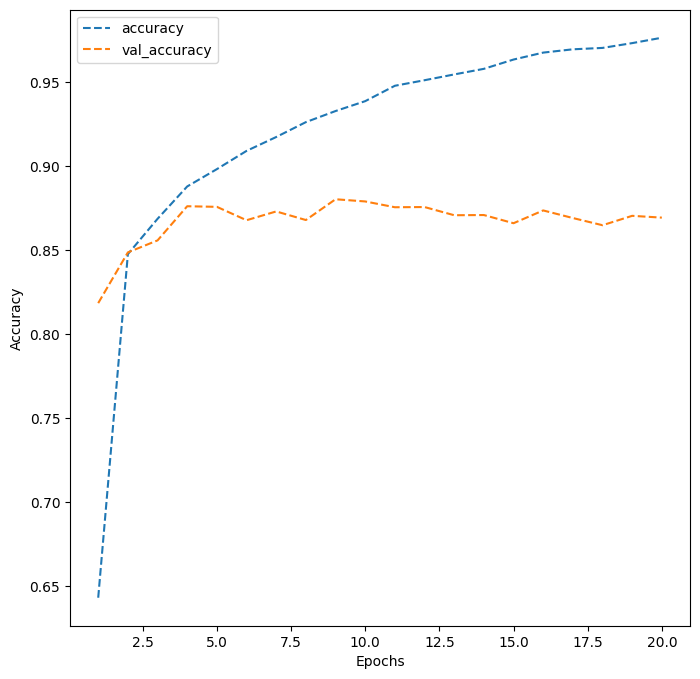

In [18]:
# Plotting the accuracies

dict_hist = history_model_1.history
list_ep = [i for i in range(1,21)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['accuracy'],ls = '--', label = 'accuracy')
plt.plot(list_ep,dict_hist['val_accuracy'],ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations:**

- The accuracy on the train set is much better (about 12%) than the validation set. We can say that model is overfitting the training data.
- The plot shows that training accuracy is increasing with epochs but the validation accuracy is more or less constant after 5 epochs.
- We can try adding dropout layers to the model's architecture to avoid overfitting. Also, we can add more convolutional layers for feature extraction.

**Let's build another model and see if we can get a better model with generalized performance.**

First, we need to clear the previous model's history from the keras backend. Also, let's fix the seed again after clearing the backend.

In [19]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [20]:
# Fixing the seed for random number generators
np.random.seed(42)

import random
random.seed(42)

tf.random.set_seed(42)

### **Second Model Architecture**
- Let's build a second model with the following architecture,
 - First Convolutional layer with **16 filters and a kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and a kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and a kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with a slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and a kernel size of 3x3 with 'same' padding** 
 - Add a **LeakyRelu layer with a slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with a slope equal to 0.1**
 - Add a **dropout layer with a rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes** and **softmax activation**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and accuracy metric**.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and 30 epochs**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture**

In [21]:
model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", input_shape=(32, 32, 1)))
model2.add(LeakyReLU(0.1))
model2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model2.add(LeakyReLU(0.1))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model2.add(LeakyReLU(0.1))
model2.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model2.add(LeakyReLU(0.1))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(32))
model2.add(LeakyReLU(0.1))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))
    
adam = optimizers.Adam(learning_rate=1e-3)
model2.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])

In [22]:
# Model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                          

**Observations:**

- Although we have added layers to the model's architecture, the total number of parameters has decreased substantially (approx 40%) compared to the previous model.
- This is due to the additional max-pooling layer that has further reduced the size of images before passing them to the dense layer. Also, we have added a dropout layer to the model. 
- All the parameters are trainable.

In [23]:
# Fit the model
history_model_2 = model2.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, verbose=1)

Epoch 1/30
263/263 [==============================] - 7s 13ms/step - loss: 1.3227 - accuracy: 0.5506 - val_loss: 2.3768 - val_accuracy: 0.2671
Epoch 2/30
263/263 [==============================] - 3s 10ms/step - loss: 0.6655 - accuracy: 0.7942 - val_loss: 0.6639 - val_accuracy: 0.7967
Epoch 3/30
263/263 [==============================] - 3s 12ms/step - loss: 0.5509 - accuracy: 0.8337 - val_loss: 0.4567 - val_accuracy: 0.8655
Epoch 4/30
263/263 [==============================] - 3s 10ms/step - loss: 0.4881 - accuracy: 0.8518 - val_loss: 0.4095 - val_accuracy: 0.8823
Epoch 5/30
263/263 [==============================] - 3s 10ms/step - loss: 0.4380 - accuracy: 0.8636 - val_loss: 0.4759 - val_accuracy: 0.8635
Epoch 6/30
263/263 [==============================] - 3s 10ms/step - loss: 0.4010 - accuracy: 0.8755 - val_loss: 0.4074 - val_accuracy: 0.8824
Epoch 7/30
263/263 [==============================] - 3s 10ms/step - loss: 0.3806 - accuracy: 0.8827 - val_loss: 0.4266 - val_accuracy: 0.8843

### **Plotting the validation and training accuracies**

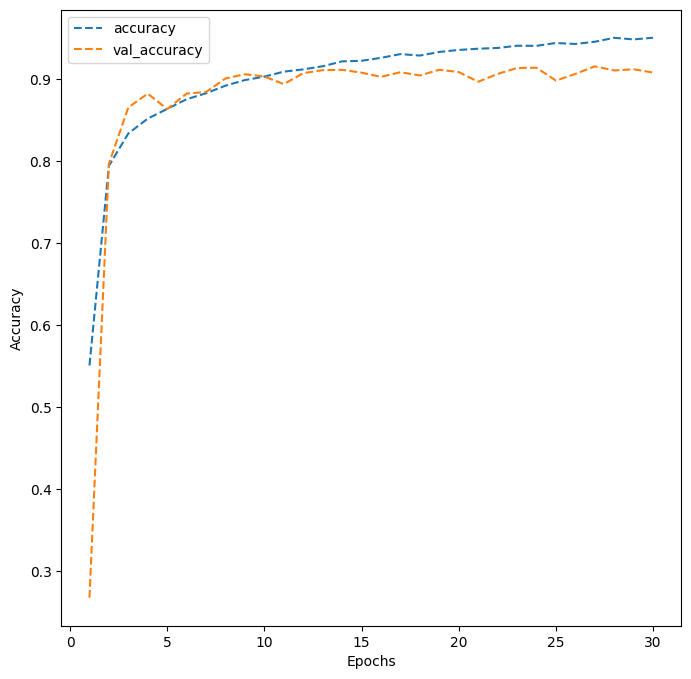

In [24]:
# Plotting the accuracies

dict_hist = history_model_2.history
list_ep = [i for i in range(1,31)]

plt.figure(figsize = (8,8))
plt.plot(list_ep,dict_hist['accuracy'],ls = '--', label = 'accuracy')
plt.plot(list_ep,dict_hist['val_accuracy'],ls = '--', label = 'val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

**Observations:**

- The second model which has more convolutional layers and less complex in terms of the number of parameters is performing significantly better than the first model.
- The overfitting has reduced significantly. The model is giving a generalized performance.  
- As you can see in the graph, validation is almost constant after the epoch 15 which might be due to the plateau region (saddle point or local extremum). We can try adjusting the learning rate during the plateau region. 

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [25]:
test_pred = model2.predict(X_test)
test_pred = np.argmax(test_pred, axis=-1)

563/563 [==============================] - 1s 2ms/step


**Note:** Earlier, we noticed that each entry of the test data is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [26]:
# Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(y_test, axis=-1)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1814
           1       0.91      0.89      0.90      1828
           2       0.91      0.92      0.91      1803
           3       0.91      0.87      0.89      1719
           4       0.93      0.91      0.92      1812
           5       0.92      0.91      0.91      1768
           6       0.89      0.89      0.89      1832
           7       0.92      0.93      0.92      1808
           8       0.90      0.88      0.89      1812
           9       0.88      0.92      0.90      1804

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000



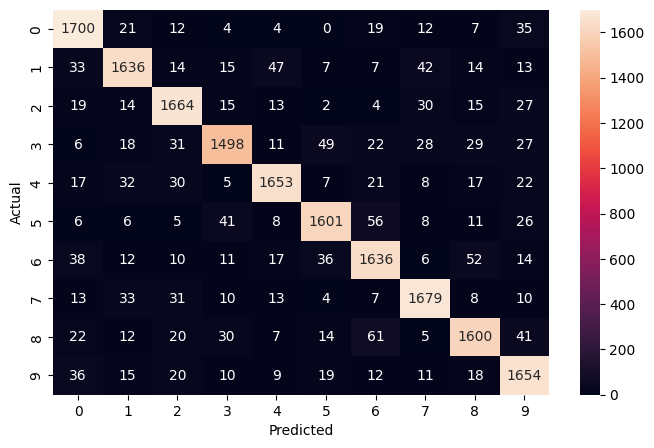

In [28]:
# Importing required functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Printing the classification report
print(classification_report(y_test, test_pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### **Observations:**

- The accuracy is **91% on the test set.** This is comparable with the results on the validation set which implies that the model is giving a generalized performance.
- This performance is significantly better than the performance of the final model using simple feed-forward neural networks. This suggests that **CNNs are a better choice for this particular dataset.**
- The recall values for all the digits are higher than or equal to 88% with 3 having the least recall. The confusion matrix shows that the model has confused 3 with digits 5 and 8 the most number of times.
- The same can be observed for digits 1 and 8 as well. The model has confused digits 1 and 8 with 4 and 6 respectively.
- The highest recall of about 95% is for digit 0 i.e. the model can identify 95% of images with digit 0.
- **The precision values show that the model is also precise in its prediction, and not just sacrificing precision for recall.** All digits have precision greater than or equal to 85% with 7 having the highest precision of 94%. This indicates that it is easier for the model to identify images with digits 7.
- The class with the least precision is digit 8 and 1. 

**Note:**

- We can try hyperparameter tuning to get an even better performance.
- Data Augmentation might help to make the model more robust and invariant toward different orientations.
- We can also try techniques like transfer learning and see if we can get better results.